<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/2_2_AutoEncoder_samplecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.라이브러리, 환경설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms

In [2]:
# GPU 사용 가능하면 GPU, 아니면 CPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

device : cpu


# 2.MNIST 데이터셋 로드

In [3]:
# 손글씨 숫자 데이터셋 (0~9) 로드
# 훈련용 MNIST 데이터셋
trainset = torchvision.datasets.MNIST(root='data',
                                      train=True,
                                      transform=transforms.ToTensor(),
                                      download=True)

# 테스트용 MNIST 데이터셋
testset = torchvision.datasets.MNIST(root='data',
                                     train=False,
                                     transform=transforms.ToTensor(),
                                     download=True)

# 데이터 로더 (배치 크기 64로 증가):데이터를 배치 단위로 불러오는 로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
# torchvision.datasets. 다양한 데이터들 있다.
# trainloader shuffle true로 셔플하여 학습하는데 더 도움됨
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
# 학습이 잘 되었는지 확인하는 testset
# train, test 다른 데이터로 되어 있어야함 완전하게 분리 해놓고 학습해야함
# train 과 test 는 비슷한 분류? 치와와 학습하고 치와와 없는 테스트 하면 안됨
# testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# 3.일반적인 오토인코더 클래스 (AE)

In [4]:
# Encoder : Dense(784 -> 128), Dense(128 -> 64), Dense(64 -> 32)
# Decoder : Dense(32 -> 64), Dense(64 -> 128), Dense(128 -> 784)
# Dense Layer를 사용한 오토인코더
class AE(nn.Module):
    def __init__(self) :
        super(AE, self).__init__()
        #Encoder: 점점 작아짐 (압축)
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),  # 784개 픽셀 → 128개로 압축
            nn.ReLU(),            # 활성화 함수(음수를 0으로 만듦)
            nn.Linear(128, 64),   # 128개 → 64개로 더 압축
            nn.ReLU(),
            nn.Linear(64, 32)     # 64개 → 32개로 최종 압축 (잠재공간)(가장 중요한 특징만 남김)
        )

        # Decoder: 점점 커짐 (복원)
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),    # 32개 → 64개로 확장:32개 특징을 64개로 확장
            nn.ReLU(),
            nn.Linear(64, 128),   # 64개 → 128개로 확장
            nn.ReLU(),
            nn.Linear(128, 784)   # 128개 → 784개로 원본 크기 복원:픽셀로 완전 복원
        )

    def forward(self, x):
        encoded = self.encoder(x)      # 입력을 압축
        decoded = self.decoder(encoded) # 압축된 것을 복원
        return decoded, encoded        # 복원된 이미지와 압축된 특징 둘 다 반환

##모델 훈련

In [5]:
model = AE()# Dense 오토인코더
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [6]:
loss_fn = nn.MSELoss()                         # 평균제곱오차 (원본과 복원 이미지의 차이 측정)
optim = opt.Adam(model.parameters(), lr=0.001) # Adam 최적화 알고리즘

# Training
epochs = 10 # 전체 데이터를 10번 반복 학습

for epoch in range(epochs): # 에폭
    for data in trainloader: # 스택
        inputs,  _ = data # 오토인코더는 라벨(정답)이 필요하지 않아서 _로 표현: 입력=출력
        print(inputs.shape)#torch.Size([배치크기, 1, 28, 28])
        # view는 텐서가 메모리에 연속적으로 저장되어 있을 때만 사용할 수 있습니다.
        # view와 reshape는 텐서의 모양을 변경하는 데 사용되는 비슷한 함수이지만, reshape가 메모리 연속성 제약 없이 더 유연하게 사용할 수 있습니다. 대부분의 경우에는 reshape를 사용해도 무방하며, view는 성능 최적화를 위해 메모리 연속성이 보장될 때 사용될 수 있습니다.
        # inputs = inputs.view(-1, 28*28).to(device) #inputs.view(-1, 28*28): 여기서 -1은 PyTorch에게 "알아서 계산해달라"는 의미입니다. 28*28은 두 번째 차원의 크기를 784로 지정한 것입니다. PyTorch는 텐서의 전체 요소 개수와 두 번째 차원의 크기(784)를 바탕으로 첫 번째 차원(배치 크기)을 자동으로 계산합니다. 즉, 텐서의 원래 배치 크기가 첫 번째 차원의 크기가 됩니다.
        inputs = inputs.view(inputs.size(0),-1).to(device) # inputs 텐서의 모양을 (배치 크기, 784)로 변경
        print(inputs.shape)# torch.Size([배치크기, 784]) # 28*28 데이터를 일자로 쫙 펴서 ??
        # break
    # break

        optim.zero_grad()        # 이전 계산의 기울기 초기화
        # 백프로파게이션 하려면 기울기 계산해서 넣는데 , 체인롤 하면 기존가지고있던 그래디언트 연속해서 곱하면 그래디언트 가지고올수있다?
        # 변수마다 자기 그래디언트 값 가지고 있는데 제로그라드로 전부 제로 만들어버림
        # 데이터 한번 돌았고 전부 초기화시켜서 다시 돌려라
        # 제로 안깔아주면 계속 누적됨
        outputs, _ = model(inputs)# 모델에 입력해서 복원된 이미지 얻기
        loss = loss_fn(outputs, inputs)# 원본과 복원 이미지의 차이 계산

        loss.backward()  # 오차 역전파 (어떻게 수정할지 계산)
        optim.step()     # 모델 가중치 업데이트

    print(f"epoch : {epoch}, loss : {loss.item()}")# 에폭마다 손실값 출력

print("finish")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64

## 결과 시각화

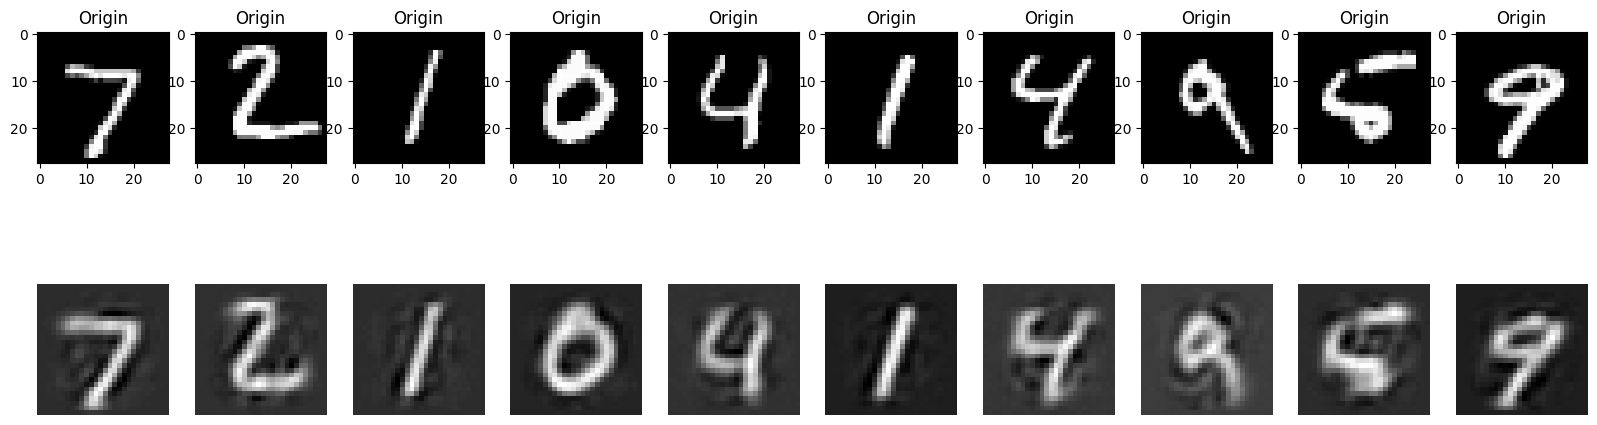

In [7]:
# 학습된 모델 저장하여 파일로 다운로드받아서 갖고 있어야지 gpu 아낌 학습에 20분 30분 오래걸림

# 눈으로 확인 그래프 그림으로 보기
import matplotlib.pyplot as plt
import numpy as np# 토치로 넘파이나 필로 형태 본다

# 테스트 데이터에서 이미지 가져오기
images, labels = next(iter(testloader))
images_flat = images.view(images.size(0), -1)# 1D로 펼치기

# 모델로 이미지 복원
recon_images_flat, encoded = model(images_flat)
recon_images = recon_images_flat.view(images.size())# 다시 2D 이미지 형태로

# 원본 vs 복원 이미지 비교 시각화
n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    # 원본 이미지 표시
    ax = plt.subplot(2, n_imgs, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')#c,h,w -> h,w,c -> h,w
    #(c,h,w):(1,2,0) -> (h,w,c) c 채널이 하나니까 있으나 없으나 같은 공간이다 그래서 squeeze로 c를 없앰->(h,w)
    ax.set_title('Origin')

    # 복원된 이미지 표시
    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().numpy(), (1,2,0)).squeeze(), cmap='gray')

    plt.axis('off')

복원된 이미지가 원본보다 흐릿하게 보이는 것은 오토인코더의 특성과 학습 과정 때문에 발생하는 일반적인 현상입니다. 몇 가지 이유가 있습니다:

1. 정보 손실 (압축): 오토인코더는 이미지를 인코더를 통해 잠재 공간(latent space)이라는 더 작은 차원으로 압축합니다. 이 과정에서 이미지의 모든 세부 정보를 완벽하게 보존하기 어렵습니다. 압축 과정에서 일부 정보가 손실되면서 복원 시 원본과 완전히 동일하게 만들어지지 못하고 세부적인 부분이 흐릿해질 수 있습니다. 특히 Dense 레이어를 사용하는 일반적인 오토인코더(AE)는 이미지를 1차원 벡터로 펼치면서 공간적인 정보 일부를 잃을 수 있습니다. CNN 오토인코더(CNNAE)는 상대적으로 공간 정보를 더 잘 보존하지만, 풀링(Pooling) 과정에서 여전히 일부 정보가 손실됩니다.
2. 평균화 경향: 오토인코더는 훈련 데이터셋의 다양한 이미지를 학습하여 평균적인 특징을 추출하는 경향이 있습니다. 특히 노이즈 제거 오토인코더의 경우, 노이즈를 제거하고 깨끗한 이미지를 복원하는 과정에서 약간의 평균화가 일어나 이미지의 선명도가 떨어질 수 있습니다.
3. 손실 함수 (MSELoss): 현재 사용하고 있는 손실 함수인 MSELoss(Mean Squared Error)는 픽셀 값의 평균 제곱 오차를 최소화하는 방향으로 학습합니다. MSELoss는 이미지의 전반적인 구조나 밝기 등을 잘 맞추는 데는 효과적이지만, 이미지의 고주파 성분(엣지, 디테일)을 완벽하게 복원하는 데는 한계가 있을 수 있습니다. 이는 결과적으로 이미지가 약간 흐릿해지는 원인이 될 수 있습니다.
4. 모델 구조의 한계: 현재 모델의 레이어 수나 채널 수가 이미지의 모든 복잡성을 완벽하게 학습하기에 충분하지 않을 수 있습니다. 더 깊거나 넓은 모델을 사용하면 복원 성능이 향상될 수도 있습니다.
5. 학습 횟수 (Epochs): 에폭 수를 늘리면 모델이 데이터를 더 많이 학습하면서 복원 성능이 개선될 수 있습니다. 하지만 너무 많이 학습하면 과적합(overfitting) 문제가 발생할 수도 있습니다.

CNN 오토인코더(CNNAE)의 경우, Dense 오토인코더(AE)보다 이미지의 공간적인 특징을 더 잘 활용하기 때문에 일반적으로 복원된 이미지가 좀 더 선명하게 보일 수 있습니다.

이미지 복원 품질을 개선하기 위해서는 다음과 같은 방법들을 시도해 볼 수 있습니다.

- 모델 구조 변경: CNN 오토인코더의 레이어 수나 필터 수를 늘리거나, 다른 종류의 레이어(예: Residual block)를 사용해 볼 수 있습니다.
- 다른 손실 함수 사용: 이미지 품질 평가에 더 적합한 SSIM (Structural Similarity Index) 같은 손실 함수나 perceptual loss를 사용해 볼 수 있습니다.
- 더 많은 학습 데이터 또는 에폭 사용: 모델이 더 다양한 이미지를 보고 학습할 기회를 늘립니다.
- 하이퍼파라미터 튜닝: 학습률(learning rate)이나 배치 크기 등을 조정해 볼 수 있습니다.
현재 복원된 이미지는 원본 이미지의 형태를 잘 파악할 수 있는 수준이므로, 오토인코더가 이미지의 주요 특징을 잘 학습했다고 볼 수 있습니다.

In [8]:
print(images.size())
print(recon_images_flat.size())
print(recon_images.size())
print(images[0].numpy().shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
(1, 28, 28)


torch.Size([64, 32])


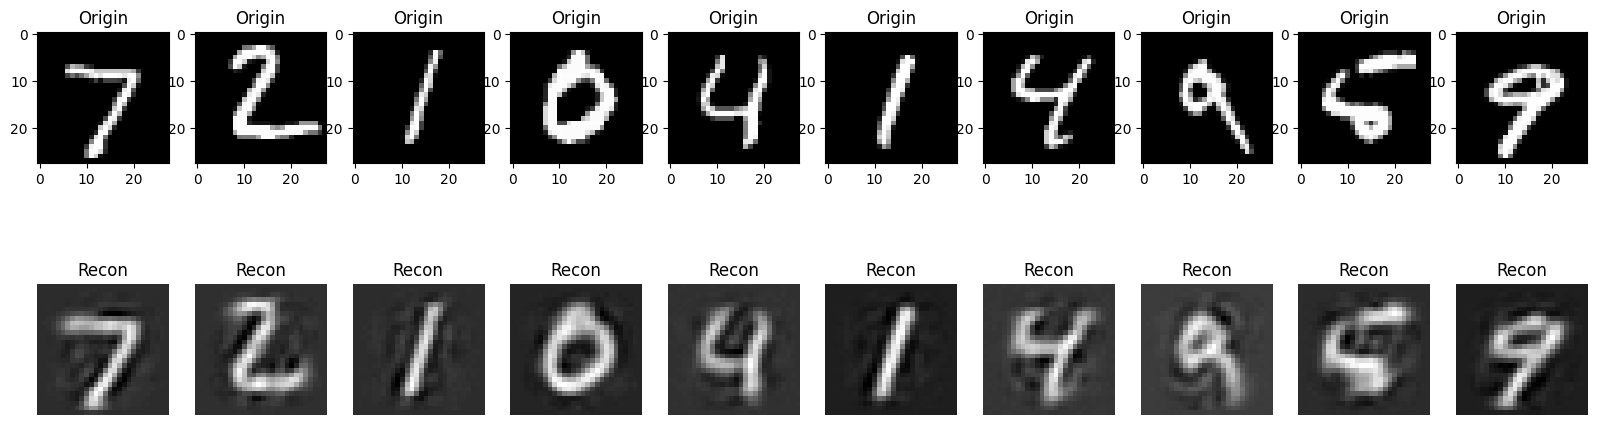

In [9]:
images, labels = next(iter(testloader))
images_flat = images.view(images.size(0), -1)

# recon_images_flat, encoded = model(images_flat)
encoded2 = model.encoder(images_flat)# 오토인코더 모델의 인코더 부분만 실행하여 원본 이미지(images_flat)를 잠재 공간 표현(encoded2)으로 압축하는 단계입니다.
print(encoded2.shape)#이 형태는 잠재 공간의 크기를 보여줍니다 (예: torch.Size([64, 32])는 배치 크기 64에 각 이미지의 특징이 32차원 벡터로 표현되었음을 의미합니다).

recon_images_flat = model.decoder(encoded2)#model.decoder(encoded2)를 직접 호출합니다. 이는 오토인코더 모델의 디코더 부분만 실행하여 인코딩된 특징(encoded2)을 입력으로 받아 복원된 이미지(recon_images_flat)를 생성하는 단계입니다.
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')#c,h,w -> h,w,c -> h,w
    #(c,h,w):(1,2,0) -> (h,w,c) c 채널이 하나니까 있으나 없으나 같은 공간이다 그래서 squeeze로 c를 없앰->(h,w)
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Recon')
    plt.axis('off')

plt.show()

In [10]:
encoded.shape

torch.Size([64, 32])

# 4.CNN 오토인코더 클래스 (CNNAE)

In [11]:
# CNN을 사용한 오토인코더
class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()
        # Encoder: 합성곱 + 풀링으로 압축
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),    # 1채널→16채널, 크기유지
            nn.ReLU(),
            # 가로세로 반반씩 사이즈 줄임
            nn.MaxPool2d(kernel_size=2, stride=2),         # 28x28 → 14x14로 크기 절반
            nn.Conv2d(16, 32, kernel_size=3, padding=1),   # 16채널→32채널
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 14x14 → 7x7로 크기 절반
        )
        # Decoder: 전치 합성곱으로 복원
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,kernel_size=2,stride=2),# 32채널 16채널로 ? 사이즈 키우기?? # 7x7 → 14x14로 크기 2배
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,kernel_size=2,stride=2),# 두배로 키움 ??# 14x14 → 28x28로 크기 2배
            nn.Sigmoid()# 0~1사이 값으로 매핑# 0~1 범위로 출력값 제한 (이미지 픽셀 값)
            )

    def forward(self, x): # 이미지 집어넣으면 도는거
        encoded = self.encoder(x)    # 이미지 압축
        decoded = self.decoder(encoded)  # 이미지 복원
        return decoded, encoded

## 모델 생성 및 설정

In [12]:
# model1=CNNAE() # CNN 오토인코더 사용
model1=CNNAE().to(device) # CNN 오토인코더 사용
print(model1) # 모델 구조 출력

CNNAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


## 모델 학습

In [13]:
loss_fn = nn.MSELoss()# 평균제곱오차 (원본과 복원 이미지의 차이)
optim = opt.Adam(model1.parameters(), lr=0.001)# Adam 최적화

# Training
epochs = 10 # 전체 데이터가 한번 다 학습하는 과정

for epoch in range(epochs): # 에폭
    for data in trainloader: # 스택
        inputs,  _ = data # 오토인코더는 라벨이 필요하지 않아서 _로 표현
        inputs = inputs.to(device)

        optim.zero_grad()# 기울기 초기화
        outputs, _ = model1(inputs)# 복원된 이미지 생성
        loss = loss_fn(outputs, inputs)# 원본과 복원 이미지 비교

        loss.backward()# 역전파
        optim.step()# 가중치 업데이트

    print(f"epoch : {epoch}, loss : {loss}")

print("finish")

epoch : 0, loss : 0.004532213322818279
epoch : 1, loss : 0.003216513665392995
epoch : 2, loss : 0.0026650705840438604
epoch : 3, loss : 0.0025625182315707207
epoch : 4, loss : 0.0027914773672819138
epoch : 5, loss : 0.002181776100769639
epoch : 6, loss : 0.0025016642175614834
epoch : 7, loss : 0.0022099458146840334
epoch : 8, loss : 0.001986744347959757
epoch : 9, loss : 0.001982497051358223
finish


## 결과 시각화

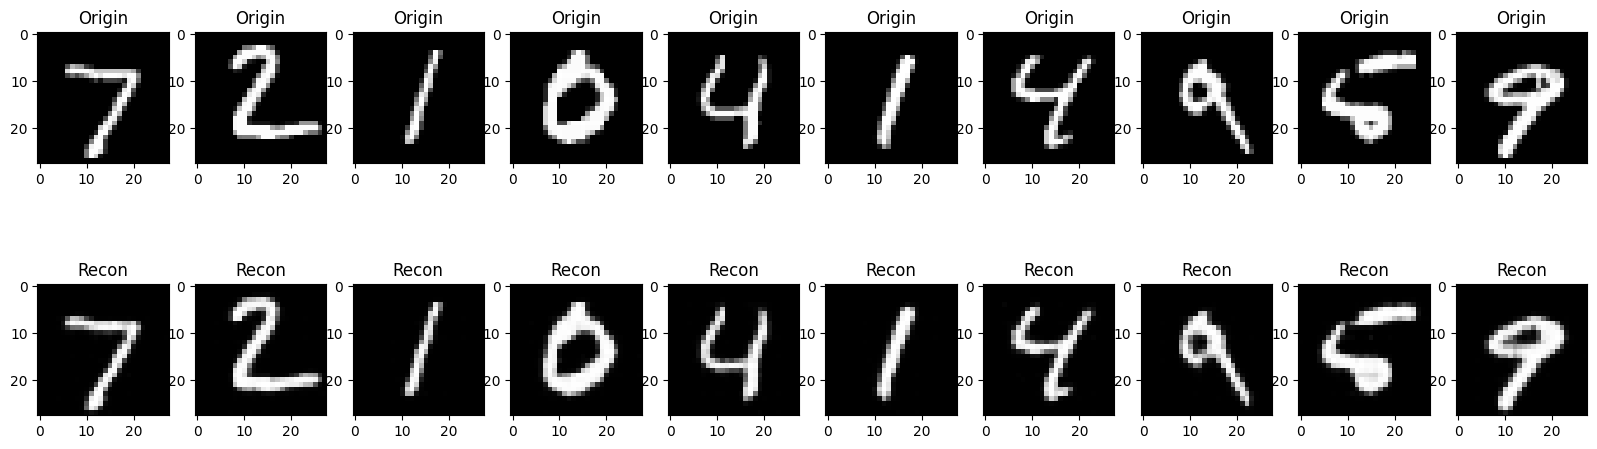

In [14]:
images, labels = next(iter(testloader))
# 🔄 전체 오토인코더를 한 번에 실행- forward() 메서드 호출
recon_images_flat, encoded = model1(images) #CNN 오토인코더가 이미지를 압축 → 복원
# recon_images_flat: 복원된 이미지 (평면화된 상태)
# recon_images: 원본과 같은 크기로 변형 (100, 1, 28, 28)
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')#c,h,w -> h,w,c -> h,w
    #(c,h,w):(1,2,0) -> (h,w,c) c 채널이 하나니까 있으나 없으나 같은 공간이다 그래서 squeeze로 c를 없앰->(h,w)
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().cpu().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Recon')

plt.show()

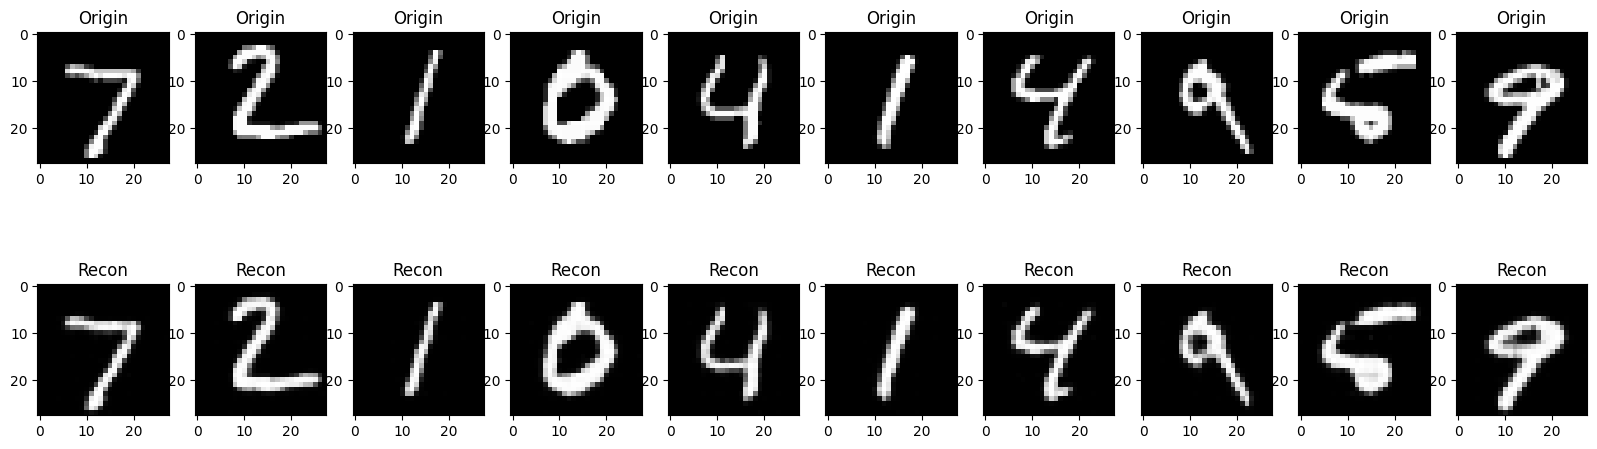

In [15]:
images, labels = next(iter(testloader))
# images_flat = images.view(images.size(0), -1) # CNN 이라서 안써도 된다.
# 🔀 인코더와 디코더를 분리해서 실행
encoded2 = model1.encoder(images.to(device))     # 1단계: 인코더만 실행
recon_images_flat = model1.decoder(encoded2)     # 2단계: 디코더만 실행

# recon_images_flat, encoded = model1(images_flat)
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    #c,h,w -> h,w,c -> h,w
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')
    #(c,h,w):(1,2,0) -> (h,w,c) c 채널이 하나니까 있으나 없으나 같은 공간이다 그래서 squeeze로 c를 없앰->(h,w)
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().cpu().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Recon')

plt.show()

In [16]:
print(images.size())
print(recon_images.size())

print(images[0].numpy().shape)
# (c,h,w):(1,2,0) -> (h, w, c) --> h, w

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
(1, 28, 28)


In [17]:
encoded.shape

torch.Size([64, 32, 7, 7])

---

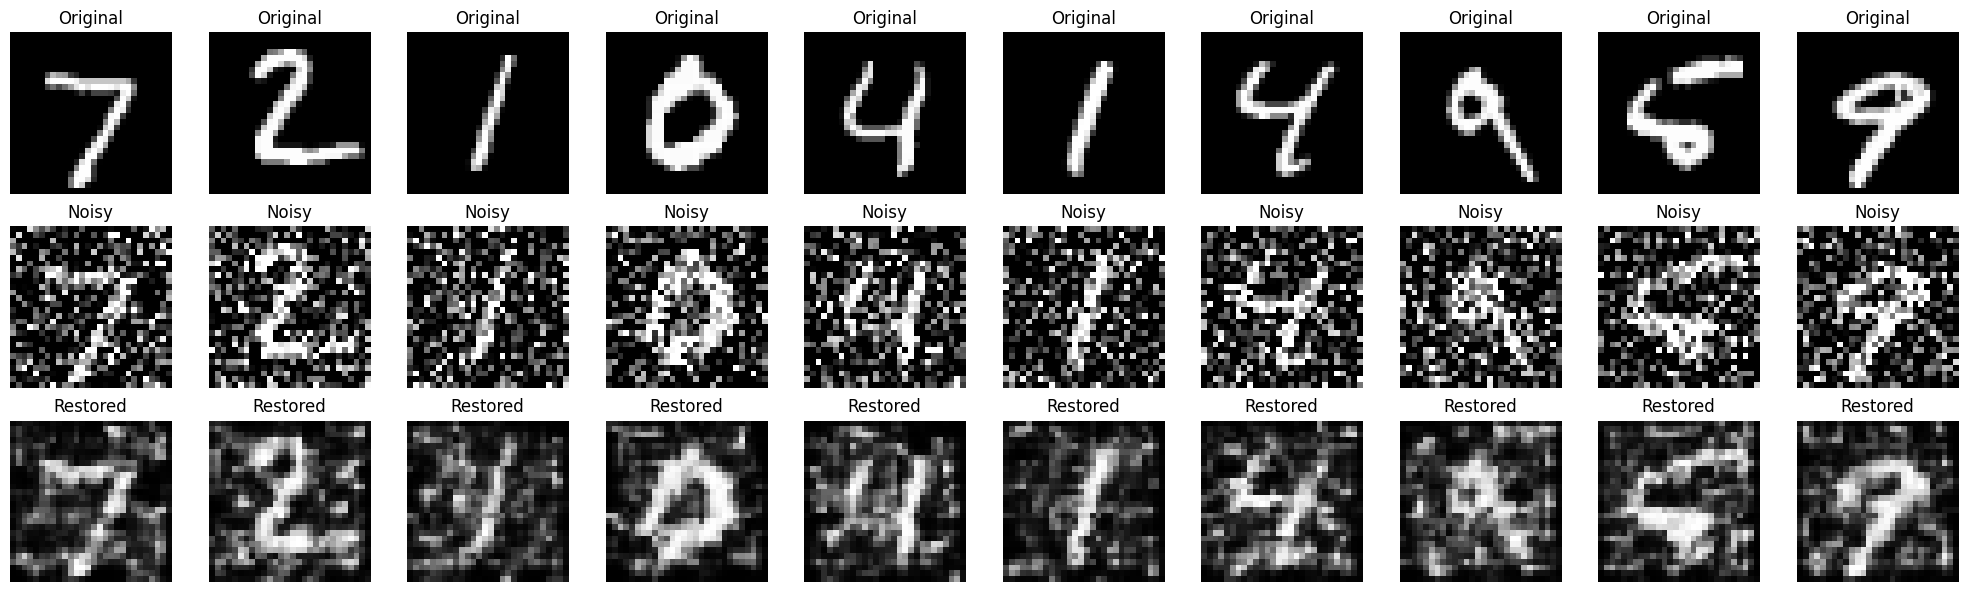

In [18]:
# 간단 버전 - 가우시안 노이즈만 테스트
images, labels = next(iter(testloader))
images = images[:10].to(device)

# 노이즈 추가
noise_factor = 0.5
noisy_images = images + noise_factor * torch.randn_like(images)
noisy_images = torch.clip(noisy_images, 0, 1)

# 복원
model1.eval()
with torch.no_grad():
    restored_images, _ = model1(noisy_images)

# 시각화
plt.figure(figsize=(20, 6))
for i in range(10):
    # 원본
    plt.subplot(3, 10, i+1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # 노이즈
    plt.subplot(3, 10, i+11)
    plt.imshow(noisy_images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # 복원
    plt.subplot(3, 10, i+21)
    plt.imshow(restored_images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Restored')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
def add_gaussian_noise(images, noise_factor=0.3):
    """가우시안 노이즈 추가 (TV 화면 지직거림 같은 효과)"""
    noisy = images + noise_factor * torch.randn_like(images)  # 랜덤 노이즈 추가
    return torch.clip(noisy, 0, 1)  # 픽셀값을 0~1 범위로 제한

def add_salt_pepper_noise(images, noise_ratio=0.1):
    """소금후추 노이즈 (점들이 찍힌 것처럼)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < noise_ratio  # 랜덤하게 픽셀 선택
    noisy[mask] = torch.rand_like(noisy[mask])    # 선택된 픽셀을 랜덤값으로 교체
    return noisy

def add_masking_noise(images, mask_ratio=0.3):
    """마스킹 (부분적으로 가리기 - 낙서 제거와 유사)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < mask_ratio  # 랜덤하게 영역 선택
    noisy[mask] = 0  # 선택된 영역을 검은색으로 마스킹
    return noisy


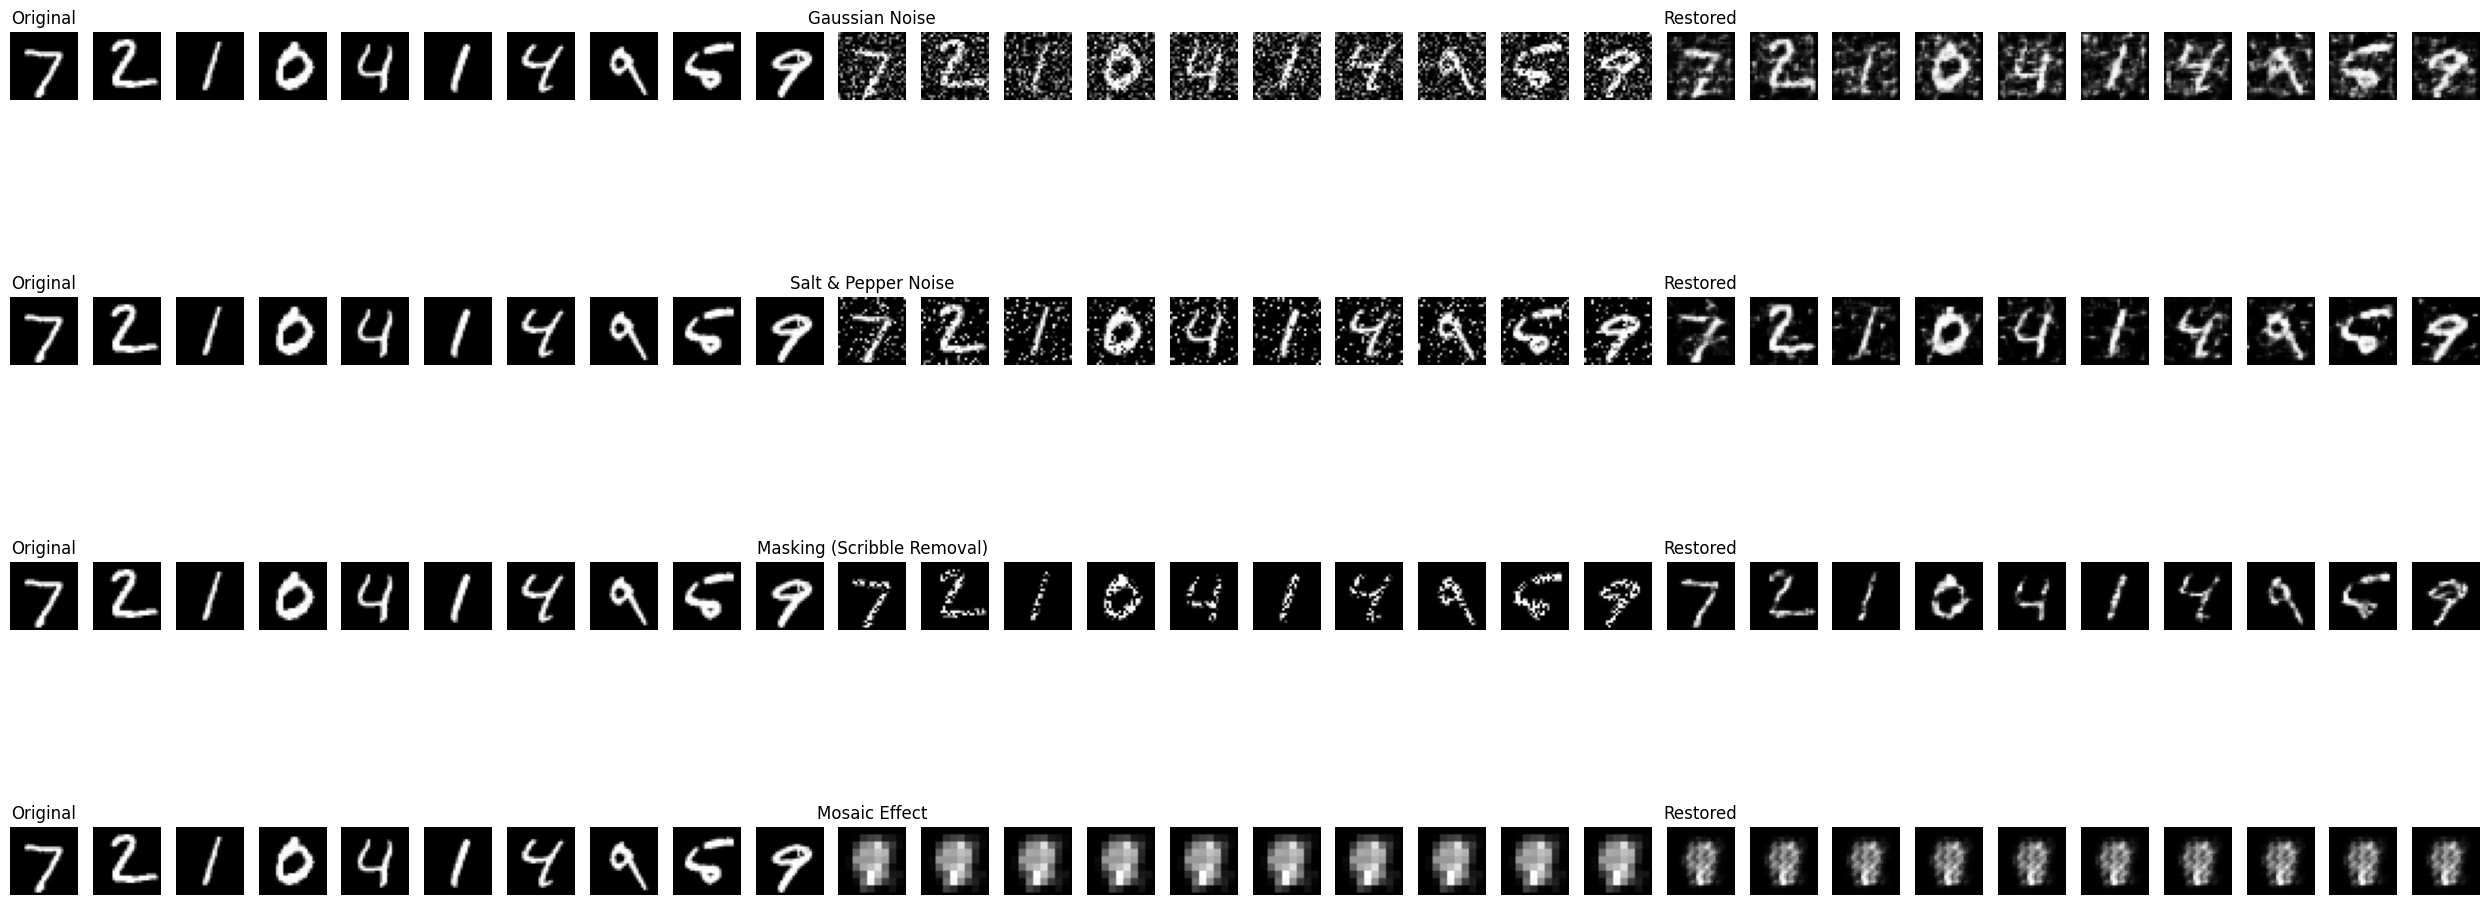

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. 다양한 노이즈 추가 함수들
def add_gaussian_noise(images, noise_factor=0.3):
    """가우시안 노이즈 추가 (TV 화면 지직거림 같은)"""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clip(noisy, 0, 1)  # 0~1 범위로 제한

def add_salt_pepper_noise(images, noise_ratio=0.1):
    """소금후추 노이즈 (점들이 찍힌 것처럼)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < noise_ratio
    noisy[mask] = torch.rand_like(noisy[mask])  # 랜덤 값으로 대체
    return noisy

def add_masking_noise(images, mask_ratio=0.3):
    """마스킹 (부분적으로 가리기 - 낙서 제거와 유사)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < mask_ratio
    noisy[mask] = 0  # 검은색으로 마스킹
    return noisy

def add_mosaic_effect(images, block_size=4):
    """모자이크 효과 (저화질 만들기)"""
    noisy = images.clone()
    h, w = images.shape[-2:]

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            # 각 블록의 평균값으로 채우기
            block = noisy[:, :, i:i+block_size, j:j+block_size]
            if block.numel() > 0:
                avg_val = block.mean()
                noisy[:, :, i:i+block_size, j:j+block_size] = avg_val

    return noisy

# 2. 노이즈 제거 테스트
def test_denoising(model, test_images, noise_type='gaussian'):
    """다양한 노이즈로 오토인코더 테스트"""
    model.eval()

    # 노이즈 추가
    if noise_type == 'gaussian':
        noisy_images = add_gaussian_noise(test_images, 0.4)
        title = 'Gaussian Noise'
    elif noise_type == 'salt_pepper':
        noisy_images = add_salt_pepper_noise(test_images, 0.15)
        title = 'Salt & Pepper Noise'
    elif noise_type == 'masking':
        noisy_images = add_masking_noise(test_images, 0.4)
        title = 'Masking (Scribble Removal)'
    elif noise_type == 'mosaic':
        noisy_images = add_mosaic_effect(test_images, 3)
        title = 'Mosaic Effect'

    # 모델로 복원
    with torch.no_grad():
        noisy_images = noisy_images.to(device)
        restored_images, _ = model(noisy_images)

    return noisy_images.cpu(), restored_images.cpu(), title

# 3. 실제 테스트 실행
images, labels = next(iter(testloader))
images = images[:10]  # 10개만 사용

# 여러 노이즈 타입으로 테스트
noise_types = ['gaussian', 'salt_pepper', 'masking', 'mosaic']

fig, axes = plt.subplots(len(noise_types), 30, figsize=(25, 12))

for noise_idx, noise_type in enumerate(noise_types):
    # 노이즈 추가 및 복원
    noisy_imgs, restored_imgs, title = test_denoising(model1, images, noise_type)

    # 첫 10개 이미지만 시각화
    for i in range(10):
        # 원본
        axes[noise_idx, i].imshow(images[i].squeeze().numpy(), cmap='gray')
        axes[noise_idx, i].set_title('Original' if i == 0 else '')
        axes[noise_idx, i].axis('off')

        # 노이즈 있는 이미지
        axes[noise_idx, i+10].imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
        axes[noise_idx, i+10].set_title(f'{title}' if i == 0 else '')
        axes[noise_idx, i+10].axis('off')

        # 복원된 이미지
        axes[noise_idx, i+20].imshow(restored_imgs[i].squeeze().numpy(), cmap='gray')
        axes[noise_idx, i+20].set_title('Restored' if i == 0 else '')
        axes[noise_idx, i+20].axis('off')

plt.tight_layout()
plt.show()


In [21]:
model2=CNNAE().to(device) # CNN 오토인코더 사용
print(model2) # 모델 구조 출력

# Denoising AutoEncoder 학습 방식
for epoch in range(epochs):
    for data in trainloader:
        clean_images, _ = data
        clean_images = clean_images.to(device)

        # 학습 시에 노이즈 추가!
        noisy_images = add_gaussian_noise(clean_images, 0.3)

        optim.zero_grad()
        outputs, _ = model2(noisy_images)  # 노이즈 입력
        loss = loss_fn(outputs, clean_images)  # 깨끗한 이미지와 비교!
        loss.backward()
        optim.step()

CNNAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [22]:
# 모델 저장
model_save_path = 'autoencoder_cnn.pth'
torch.save(model1.state_dict(), model_save_path)
print(f"모델이 {model_save_path}에 저장되었습니다.")

# 저장된 모델 불러오기 (새로운 모델 인스턴스를 생성한 후 state_dict를 로드합니다.)
# model1_loaded = CNNAE().to(device) # 만약 GPU를 사용했다면 .to(device) 추가
# model1_loaded.load_state_dict(torch.load(model_save_path))
# model1_loaded.eval() # 불러온 모델을 평가 모드로 설정 (드롭아웃 등 비활성화)

# print("모델이 성공적으로 로드되었습니다.")

모델이 autoencoder_cnn.pth에 저장되었습니다.


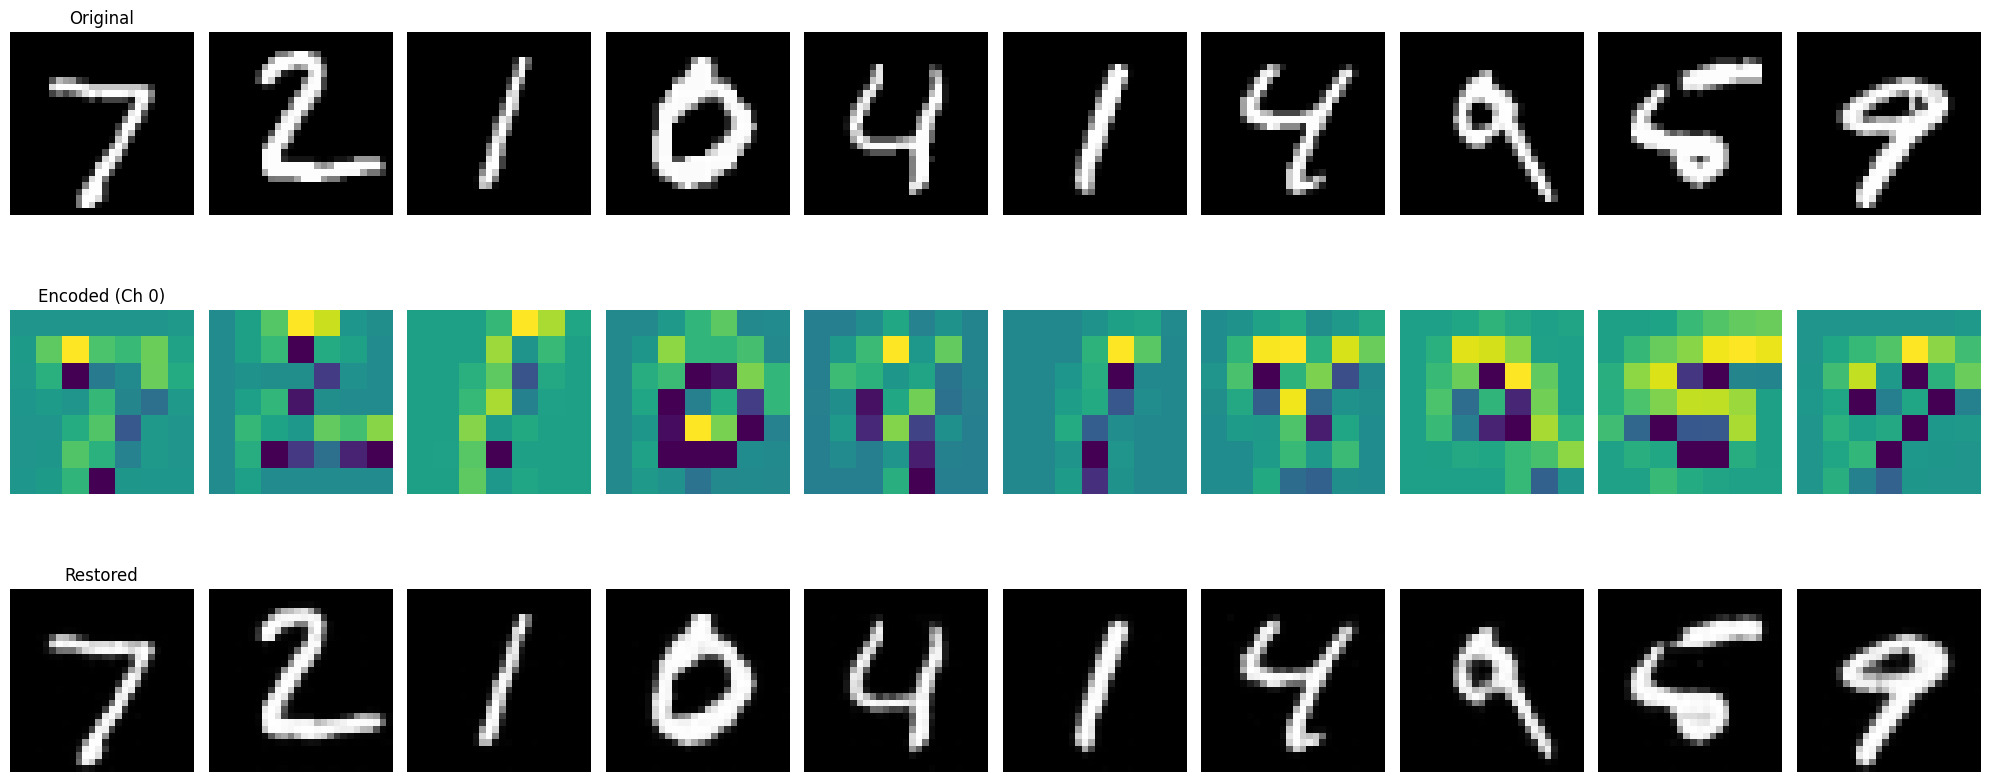

In [23]:
# import matplotlib.pyplot as plt
# import numpy as np

# 테스트 데이터에서 이미지 가져오기
images, labels = next(iter(testloader))
images = images[:10] # 처음 10개 이미지만 사용
# images = images.to(device) # GPU 사용 시 주석 해제

# CNN 오토인코더 모델 (model2) 사용
model2.eval() # 평가 모드로 설정 (드롭아웃 등 비활성화)

with torch.no_grad(): # 기울기 계산 비활성화 (메모리 절약, 속도 향상)
    # 인코딩
    encoded_images = model1.encoder(images)
    # 디코딩
    restored_images = model1.decoder(encoded_images)

# 시각화 (원본 - 인코딩 결과 - 복원 결과)
n_imgs = 10
plt.figure(figsize=(20, 9)) # 그림 크기 설정 (세 줄이므로 높이 증가)

for i in range(n_imgs):
    # 원본 이미지 (첫 번째 줄)
    ax = plt.subplot(3, n_imgs, i + 1)
    # C, H, W -> H, W, C 순서로 변경 (Matplotlib 시각화용)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    ax.set_title('Original' if i == 0 else '') # 첫 번째 이미지에만 제목 표시
    plt.axis('off') # 축 숨기기

    # 인코딩된 결과 (두 번째 줄) - 여기서는 첫 번째 채널만 시각화
    ax = plt.subplot(3, n_imgs, i + 1 + n_imgs)
    # 인코딩된 결과: (channels, height, width). 시각화를 위해 (height, width) 형태로 변환.
    # encoded_images[i, 0, :, :]는 i번째 이미지의 0번째 채널 (7x7)
    plt.imshow(encoded_images[i, 0, :, :].cpu().numpy(), cmap='viridis') # 인코딩된 특징 시각화 (컬러맵 변경)
    ax.set_title('Encoded (Ch 0)' if i == 0 else '') # 첫 번째 이미지에만 제목 표시
    plt.axis('off')

    # 복원된 이미지 (세 번째 줄)
    ax = plt.subplot(3, n_imgs, i + 1 + 2 * n_imgs)
    # 복원된 이미지: (channels, height, width) -> (height, width, channels)
    plt.imshow(np.transpose(restored_images[i].cpu().numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    ax.set_title('Restored' if i == 0 else '') # 첫 번째 이미지에만 제목 표시
    plt.axis('off')

plt.tight_layout() # 서브플롯 간 간격 조절
plt.show()